In [382]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/team1endsem/train.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [1]:
## Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/team1endsem/train.csv')
df_sample = df.sample(10000, random_state=2)
df_sample 

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0
...,...,...,...,...,...,...
225793,225793,56132,334218,Are there any Hindu rituals to summon a Demon?,Will God allow you to connect if you are not p...,0
171015,171015,264332,264333,Which is the best online platform for informat...,"Data driven or data informed, which one is the...",0
301473,301473,424385,424386,Why do people ask for very simple translations...,Why do people ask for very simple translations...,1
197504,197504,5741,7169,Can a girl get pregnant after her last day of ...,Can I get pregnant 3 days after period if I bl...,1


In [3]:
print(f"Original data size:{df.shape}")
print(f"Sample data size:{df_sample.shape}")

Original data size:(404290, 6)
Sample data size:(10000, 6)


In [4]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 398782 to 329873
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


In [5]:
df_sample["is_duplicate"].value_counts()

0    6303
1    3697
Name: is_duplicate, dtype: int64

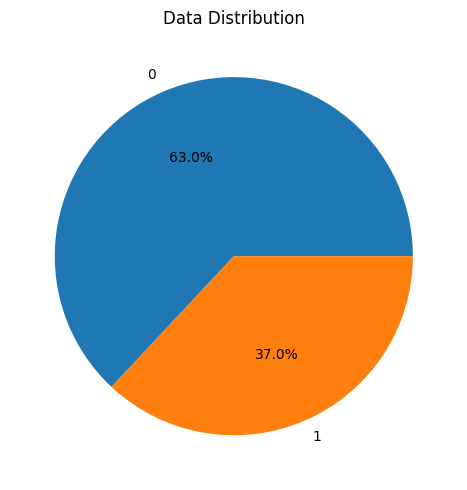

In [6]:
plt.figure(figsize=(5,5))
plt.pie(x=df_sample["is_duplicate"].value_counts().values,labels=df_sample["is_duplicate"].value_counts().index,autopct='%1.1f%%')
plt.title("Data Distribution")
plt.tight_layout()

missing values

In [7]:
df_sample.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
df_sample.duplicated().sum()

0

In [9]:
qid = pd.Series(df_sample['qid1'].tolist() + df_sample['qid2'].tolist())
print('Number of unique questions:',np.unique(qid).shape[0])
rep_ques = qid.value_counts()[qid.value_counts() > 1].count()
print('Number of questions getting repeated:',rep_ques)

Number of unique questions: 19336
Number of questions getting repeated: 588


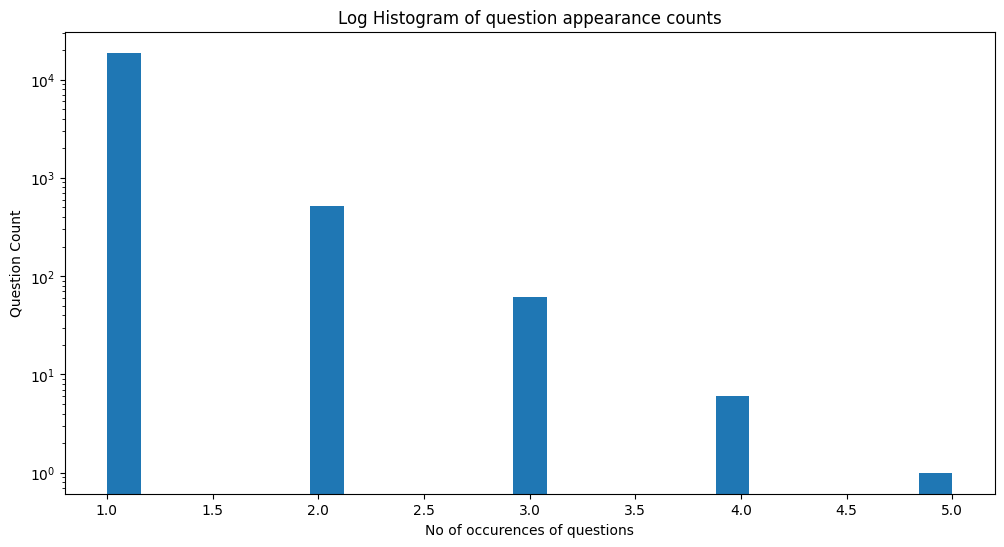

In [10]:
plt.figure(figsize=(12,6))
plt.hist(qid.value_counts().values,bins=25)
plt.yscale('log')
plt.title("Log Histogram of question appearance counts")
plt.xlabel("No of occurences of questions")
plt.ylabel("Question Count")
plt.show()

In [11]:
df_sample["question1"] = df_sample["question1"].apply(lambda x:re.sub('[^a-zA-Z]',' ',x).lower())
df_sample["question2"] = df_sample["question2"].apply(lambda x:re.sub('[^a-zA-Z]',' ',x).lower())

## Total words (token) feature
df_sample["q1_token"] = df_sample["question1"].apply(lambda x:len(x.split()))
df_sample["q2_token"] = df_sample["question2"].apply(lambda x:len(x.split()))
    
def words_func(text):
    word_count = [word for word in text.split() if word not in stopwords.words('english')]
    return len(word_count)
    
## Word count(non stopwords) in question 1 & 2
df_sample["q1_words"] = df_sample["question1"].apply(func=words_func)
df_sample["q2_words"] = df_sample["question2"].apply(func=words_func)
    
## Stopwords count in question 1 & 2
df_sample["q1_stops"] = df_sample["q1_token"] - df_sample["q1_words"]
df_sample["q2_stops"] = df_sample["q2_token"] - df_sample["q2_words"]

def common_stop_counts(text):
    w_stops = [word for word in text.split() if word in stopwords.words('english')]
    return set(w_stops)
    
cs_1 = df_sample["question1"].apply(func=common_stop_counts)
cs_2 = df_sample["question2"].apply(func=common_stop_counts)
## Common stopword count
df_sample["common_stopwords"] = list(map(lambda x,y:len(x.intersection(y)),cs_1,cs_2))

In [12]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,13,13,8,8,5,5,5
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,12,15,3,4,9,11,5
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,26,20,9,11,17,9,3
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,13,30,6,12,7,18,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas trag...,0,5,9,4,5,1,4,0


In [13]:
df_sample.shape

(10000, 13)

Removing Stopwords and Special Characters

In [14]:
def text_cleaning_fun(text):
    # only alphabetical characters
    words = re.sub('[^a-zA-Z]',' ',text)
    # Convert every word into lowercase
    words = words.lower()
    # Create list out of string
    word_list = words.split()
    # Remove stopwords
    remove_stopwords=[word for word in word_list if word not in stopwords.words('english')]

    final_str = ' '.join(remove_stopwords)
    return final_str

In [15]:
df_sample["question1"] = df_sample["question1"].apply(func=text_cleaning_fun)
df_sample["question2"] = df_sample["question2"].apply(func=text_cleaning_fun)

In [16]:
df_sample["question1"].iloc[5]

'killed snake friday belief kill snake friday certainly take revenge killed'

In [17]:
df_sample["question2"].iloc[5]

'snakes really take revenge'

Wordcloud for question 1 & 2 feature column (is_duplicate = 1)

In [18]:
word_list_1 = df_sample[df_sample["is_duplicate"]==1]["question1"].values + df_sample[df_sample["is_duplicate"]==1]["question2"].values
word_list_1[:5]

array(['best marketing automation tool small mid size companiesbest marketing automation tool small mid sized companies',
       'funny lies narendra moditrolls narendra modi',
       'would like start watching doctor startnew viewer season start watching doctor',
       'heaven described bibleheaven described according bible',
       'really like shotfeel like shot'], dtype=object)

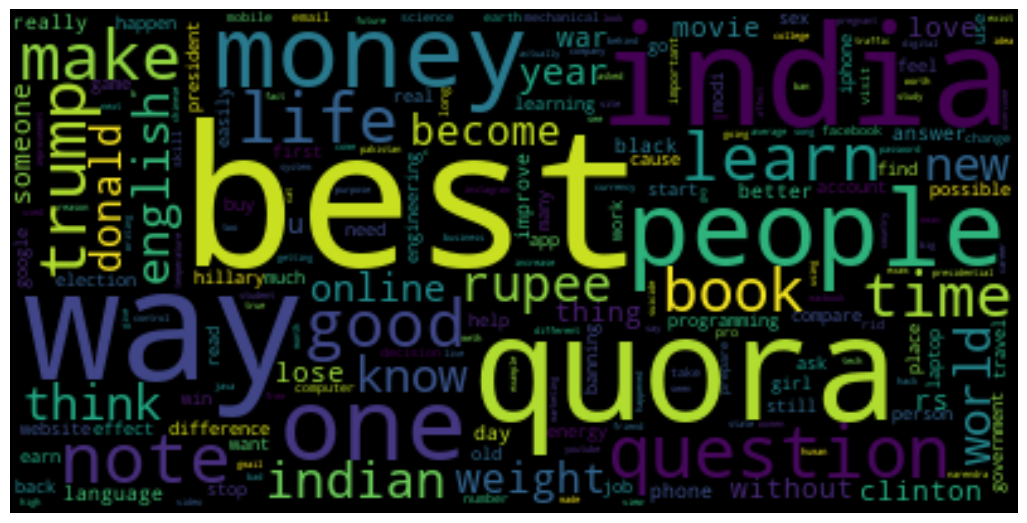

In [19]:
plt.figure(figsize=(13,13))
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(' '.join(word_list_1))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
word_list_0 = df_sample[df_sample["is_duplicate"]==0]["question1"].values + df_sample[df_sample["is_duplicate"]==0]["question2"].values
word_list_0[:5]

array(['poor want investquite poor want rich',
       'india live abroad met guy france party want datee thapar university thapar university institute engineering technology anyone explain shit',
       'many people u hate southern statesboyfriend doesnt feel guilty hurts cried telling killed cat young could psychopath',
       'consequences bhopal gas tragedyreason behind bhopal gas tragedy',
       'killed snake friday belief kill snake friday certainly take revenge killedsnakes really take revenge'],
      dtype=object)

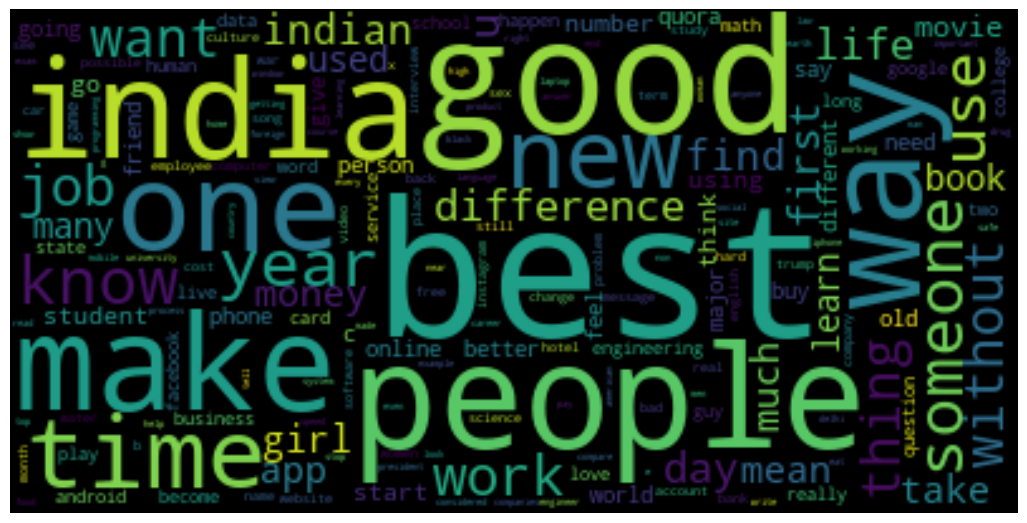

In [22]:
plt.figure(figsize=(13,13))
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(' '.join(word_list_0))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Performing Stemming

In [23]:
port_stem = PorterStemmer()
def stemming_func(text):
    word_list=text.split()
    # Apply Stemming
    stem_words=[port_stem.stem(word) for word in word_list]
    final_str = ' '.join(stem_words)
    return final_str

In [24]:
df_sample["question1"] = df_sample["question1"].apply(func=stemming_func)
df_sample["question2"] = df_sample["question2"].apply(func=stemming_func)

In [25]:
df_sample["question1"].iloc[5]

'kill snake friday belief kill snake friday certainli take reveng kill'

In [26]:
df_sample["question2"].iloc[5]

'snake realli take reveng'

Lemmatization

In [27]:
def lemmatization_func(text):
    lemma = WordNetLemmatizer()
    word_list = text.split()
    lamma_words = [lemma.lemmatize(word,pos='v') for word in word_list]
    final_str = ' '.join(lamma_words)
    return final_str  

In [29]:
import nltk
nltk.download('wordnet')
nltk.download('all-corpora')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /usr/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat

True

In [31]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [32]:
df_sample["question1"] = df_sample["question1"].apply(func=lemmatization_func)
df_sample["question2"] = df_sample["question2"].apply(func=lemmatization_func)

In [33]:
df_sample["question1"].iloc[5]

'kill snake friday belief kill snake friday certainli take reveng kill'

In [34]:
df_sample["question2"].iloc[5]

'snake realli take reveng'

In [35]:
df_sample.shape

(10000, 13)

In [36]:
def basic_feature_func(df):
    df['q1_len'] = df['question1'].str.len() 
    df['q2_len'] = df['question2'].str.len()

    def common_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2'].split(" ")))
        return len(w1 & w2) # Using sets intersection
    
    df['word_common'] = df.apply(func=common_words, axis=1)

    df["common_tokens"] = df["word_common"] + df["common_stopwords"]

    def total_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2'].split(" ")))
        return (len(w1) + len(w2))
    
    df['word_total'] = df.apply(func=total_words, axis=1)

    df['word_share'] = round(df['word_common']/df['word_total'],2)

    return df

In [37]:
df_QP = basic_feature_func(df_sample)
df_QP.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,word_common,common_tokens,word_total,word_share
398782,398782,496695,532029,best market autom tool small mid size compani,best market autom tool small mid size compani,1,13,13,8,8,5,5,5,45,45,8,13,16,0.50
115086,115086,187729,187730,poor want invest,quit poor want rich,0,12,15,3,4,9,11,5,16,19,2,7,7,0.29
327711,327711,454161,454162,india live abroad meet guy franc parti want date,e thapar univers thapar univers institut engin...,0,26,20,9,11,17,9,3,48,75,0,3,18,0.00
367788,367788,498109,491396,mani peopl u hate southern state,boyfriend doesnt feel guilti hurt cri tell kil...,0,13,30,6,12,7,18,0,32,74,0,0,18,0.00
151235,151235,237843,50930,consequ bhopal ga tragedi,reason behind bhopal ga tragedi,0,5,9,4,5,1,4,0,25,31,3,3,9,0.33


In [38]:
df_QP.shape

(10000, 19)

<AxesSubplot: xlabel='is_duplicate', ylabel='q1_len'>

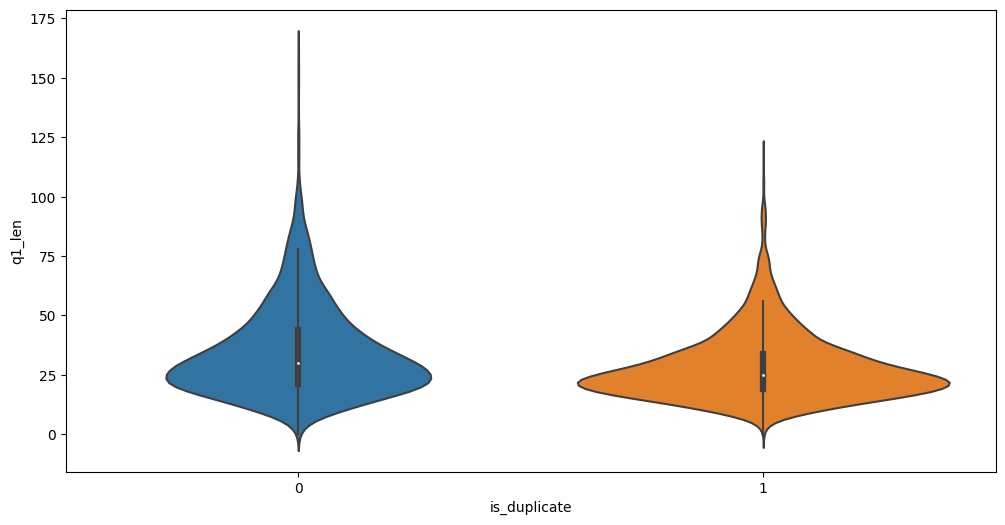

In [39]:
## q1_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_len",data=df_QP)

minimum characters 0
maximum characters 163
average num of characters 32


<Figure size 1200x600 with 0 Axes>

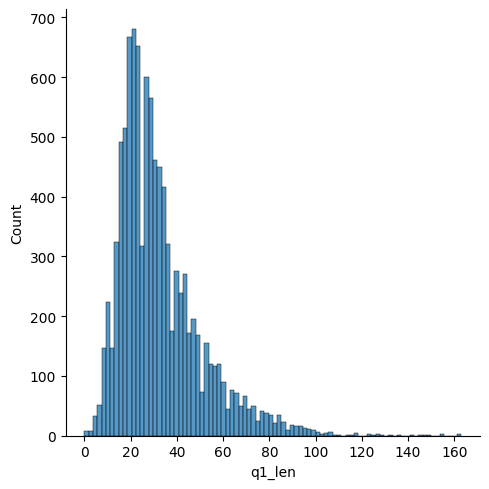

In [40]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q1_len'])
print('minimum characters',df_QP['q1_len'].min())
print('maximum characters',df_QP['q1_len'].max())
print('average num of characters',int(df_QP['q1_len'].mean()))

<AxesSubplot: xlabel='is_duplicate', ylabel='q2_len'>

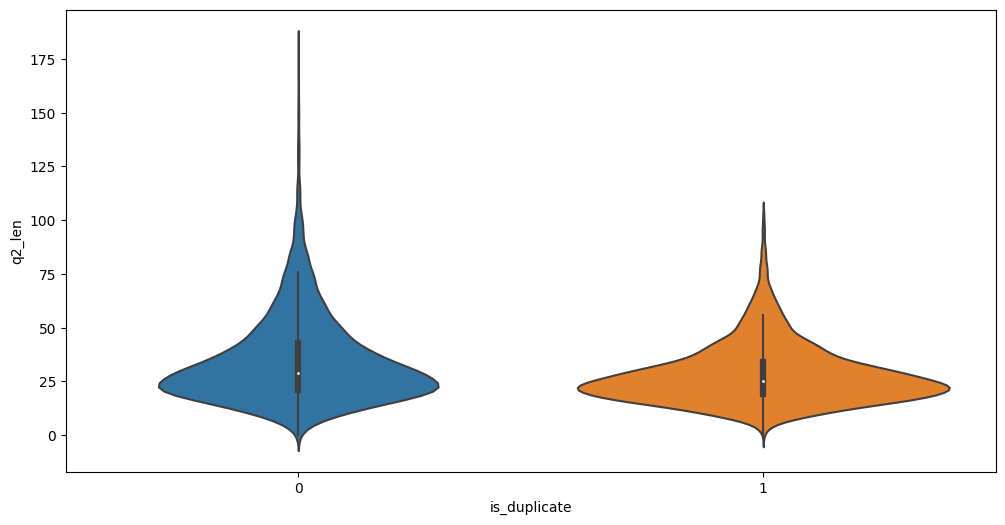

In [41]:
## q2_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_len",data=df_QP)

minimum characters 0
maximum characters 181
average num of characters 32


<Figure size 1200x600 with 0 Axes>

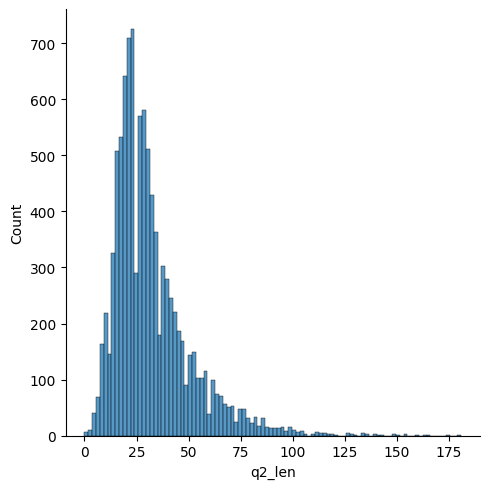

In [42]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q2_len'])
print('minimum characters',df_QP['q2_len'].min())
print('maximum characters',df_QP['q2_len'].max())
print('average num of characters',int(df_QP['q2_len'].mean()))

<AxesSubplot: xlabel='is_duplicate', ylabel='q1_words'>

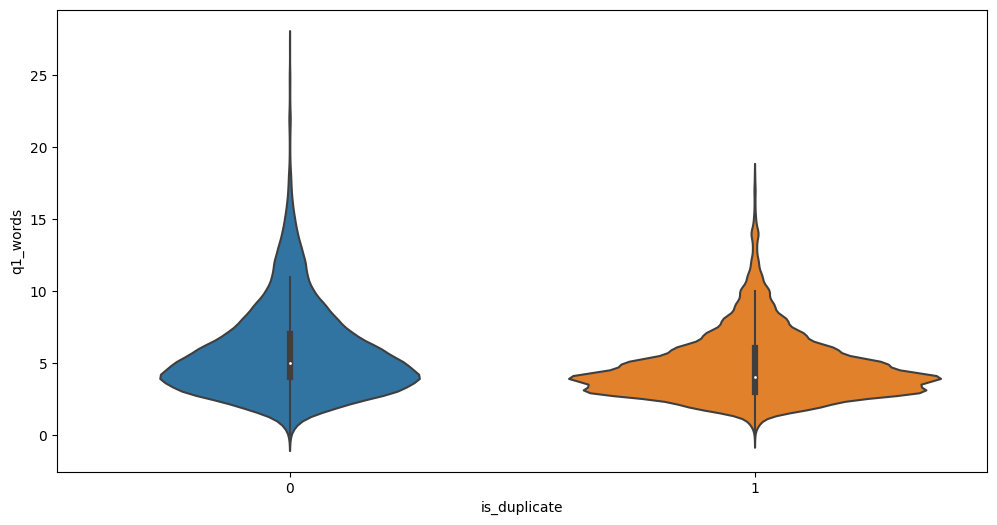

In [43]:
## q1_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_words",data=df_QP)

minimum words 0
maximum words 27
average num of words 5


<Figure size 1200x600 with 0 Axes>

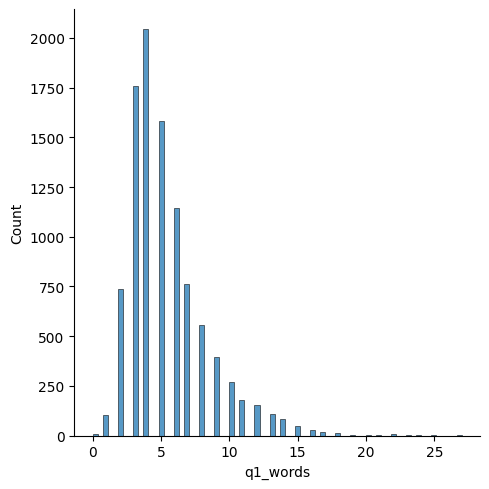

In [44]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q1_words'])
print('minimum words',df_QP['q1_words'].min())
print('maximum words',df_QP['q1_words'].max())
print('average num of words',int(df_QP['q1_words'].mean()))

<AxesSubplot: xlabel='is_duplicate', ylabel='q2_words'>

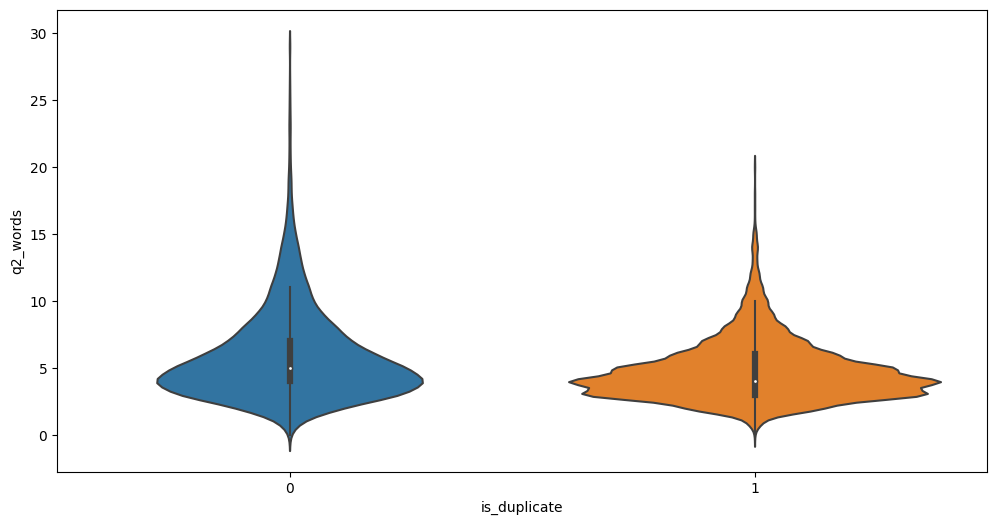

In [45]:
## q2_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_words",data=df_QP)

minimum words 0
maximum words 29
average num of words 5


<Figure size 1200x600 with 0 Axes>

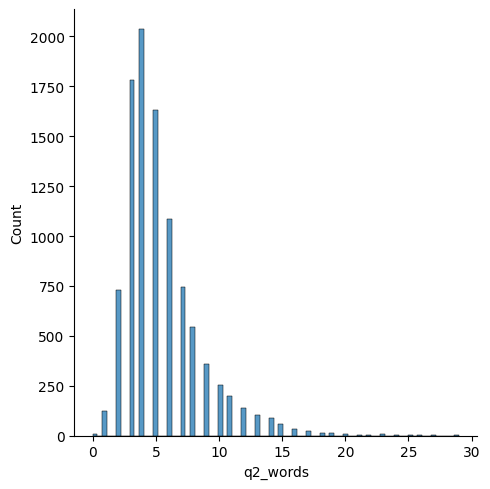

In [46]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q2_words'])
print('minimum words',df_QP['q2_words'].min())
print('maximum words',df_QP['q2_words'].max())
print('average num of words',int(df_QP['q2_words'].mean()))

<AxesSubplot: xlabel='is_duplicate', ylabel='word_common'>

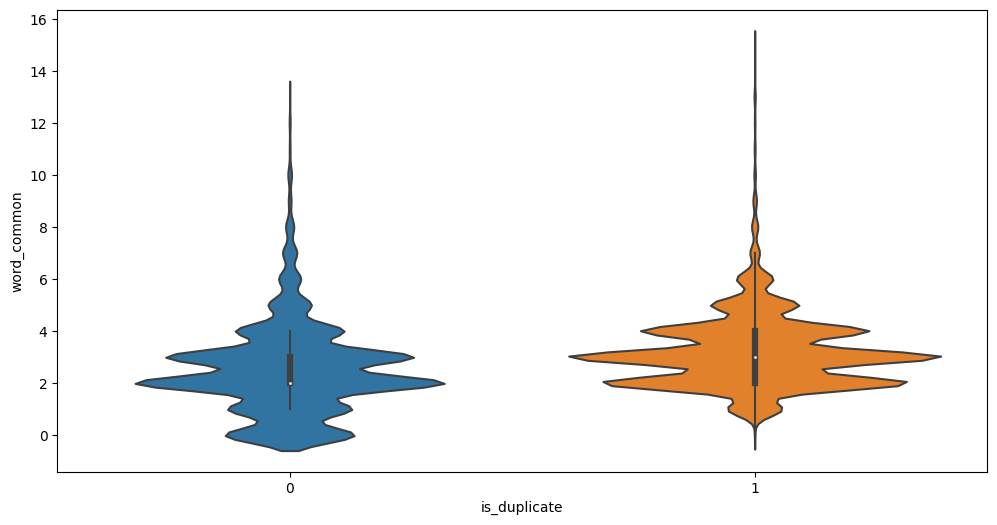

In [47]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_common",data=df_QP)

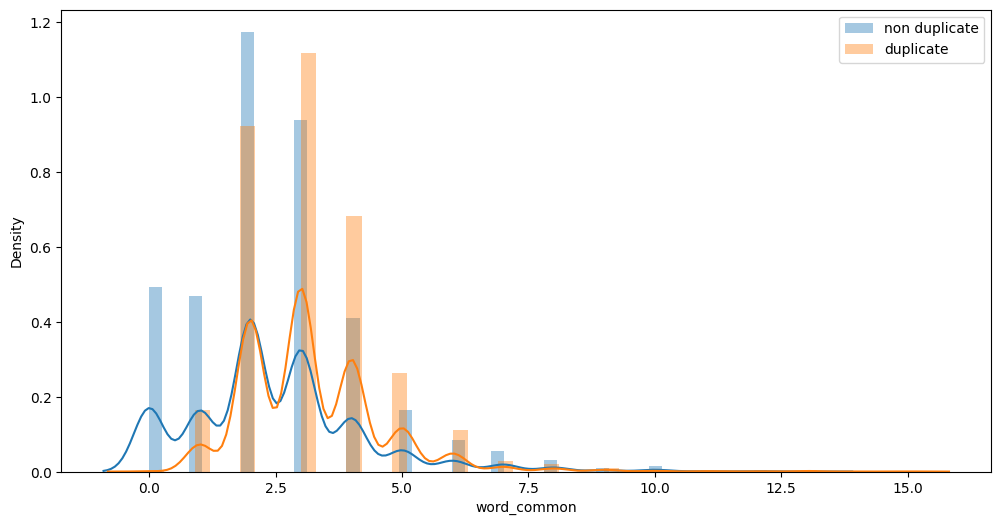

In [48]:
## Common words feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

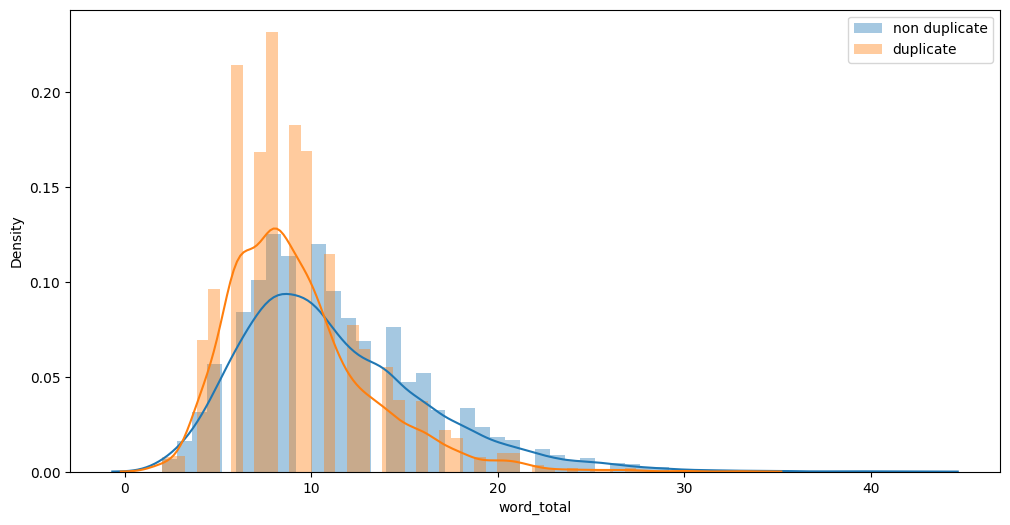

In [49]:
# Total words feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

<AxesSubplot: xlabel='is_duplicate', ylabel='word_share'>

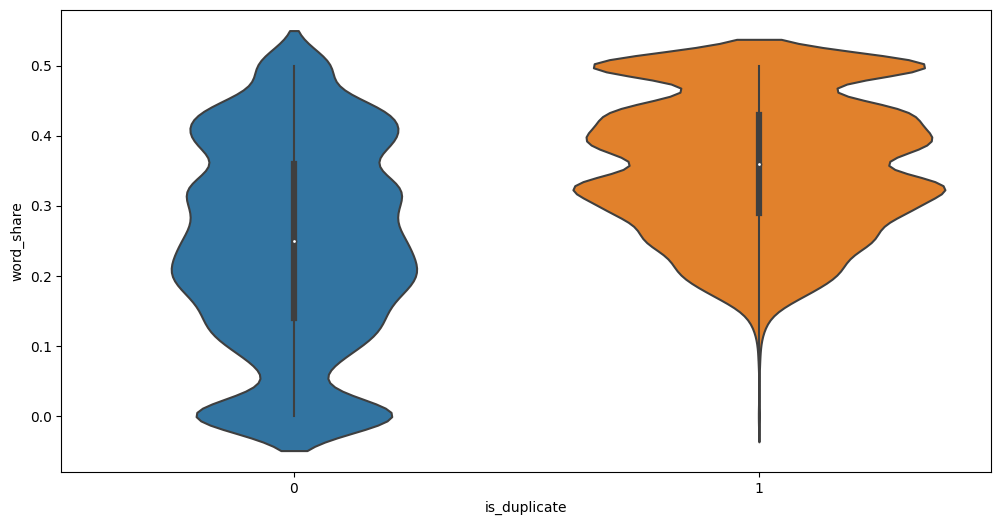

In [50]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_share",data=df_QP)

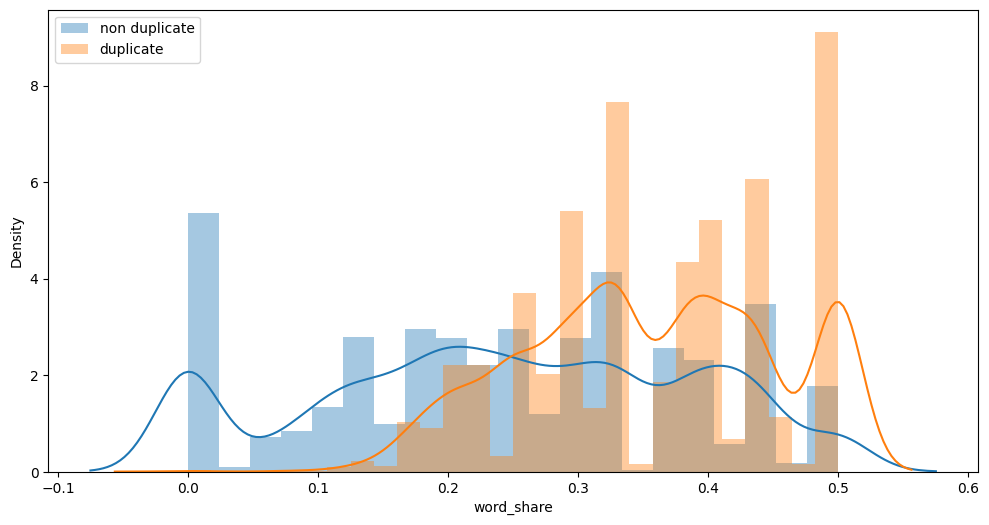

In [51]:
# Word share feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

advance features

In [52]:
feature_list = []
for i in range(df_QP.shape[0]):
    cwc_min = df_QP["word_common"].iloc[i]/min(df_QP["q1_words"].iloc[i],df_QP["q2_words"].iloc[i])
    cwc_max = df_QP["word_common"].iloc[i]/max(df_QP["q1_words"].iloc[i],df_QP["q2_words"].iloc[i])

    csc_min = df_QP["common_stopwords"].iloc[i]/min(df_QP["q1_stops"].iloc[i],df_QP["q2_stops"].iloc[i])
    csc_max = df_QP["common_stopwords"].iloc[i]/max(df_QP["q1_stops"].iloc[i],df_QP["q2_stops"].iloc[i])

    ctc_min = df_QP["common_tokens"].iloc[i]/min(df_QP["q1_token"].iloc[i],df_QP["q2_token"].iloc[i])
    ctc_max = df_QP["common_tokens"].iloc[i]/max(df_QP["q1_token"].iloc[i],df_QP["q2_token"].iloc[i])

    l1,l2 = df_QP["question1"].iloc[i].split(),df_QP["question2"].iloc[i].split()
    if(len(l1) > 0 and len(l2) > 0 and l1[-1] == l2[-1]):
        last_word = 1
    else:
        last_word = 0

    if(len(l1) > 0 and len(l2) > 0 and l1[0] == l2[0]):
        first_word = 1
    else:
        first_word = 0

    feature_list.append([cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word,last_word])

In [53]:
df_advance_feature = pd.DataFrame(feature_list,
                                  columns=["cwc_min","cwc_max","csc_min","csc_max","ctc_min","ctc_max","first_word_eq","last_word_eq"])
df_advance_feature

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
1,0.666667,0.500000,0.555556,0.454545,0.583333,0.466667,0,0
2,0.000000,0.000000,0.333333,0.176471,0.150000,0.115385,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,0.750000,0.600000,0.000000,0.000000,0.600000,0.333333,0,1
...,...,...,...,...,...,...,...,...
9995,0.250000,0.166667,0.800000,0.400000,0.555556,0.312500,0,0
9996,0.375000,0.214286,0.857143,0.666667,0.600000,0.391304,0,0
9997,0.909091,0.833333,0.800000,0.571429,0.857143,0.692308,1,1
9998,0.666667,0.500000,0.600000,0.375000,0.636364,0.437500,0,0


In [54]:
df_advance_feature.isnull().sum()

cwc_min           7
cwc_max           0
csc_min          30
csc_max           4
ctc_min           0
ctc_max           0
first_word_eq     0
last_word_eq      0
dtype: int64

In [55]:
df_advance_feature["cwc_min"] = df_advance_feature["cwc_min"].fillna(df_advance_feature["cwc_min"].mean())
df_advance_feature["csc_min"] = df_advance_feature["csc_min"].fillna(df_advance_feature["csc_min"].mean())
df_advance_feature["csc_max"] = df_advance_feature["csc_max"].fillna(df_advance_feature["csc_max"].mean())
df_advance_feature["ctc_min"] = df_advance_feature["ctc_min"].fillna(df_advance_feature["ctc_min"].mean())

In [56]:
df_advance_feature.isnull().sum()

cwc_min          0
cwc_max          0
csc_min          0
csc_max          0
ctc_min          0
ctc_max          0
first_word_eq    0
last_word_eq     0
dtype: int64

In [57]:
col_names = list(df_QP.columns) + list(df_advance_feature.columns)

In [58]:
df_QP["mean_len"] = (df_QP["q1_token"] + df_QP["q2_token"])/2
df_QP["abs_len_diff"] = abs(df_QP["q1_token"] - df_QP["q2_token"])

In [59]:
QP_array = np.concatenate((df_QP.values,df_advance_feature.values),axis=1)
col_names = list(df_QP.columns) + list(df_advance_feature.columns)
df_final = pd.DataFrame(data=QP_array,columns=col_names)

In [60]:
from fuzzywuzzy import fuzz

In [61]:
def fuzzy_func(df):
    fuzz_list=[]
    for i in range(df.shape[0]):
        # fuzz_ratio
        fuzz_qratio = fuzz.QRatio(df["question1"].iloc[i], df["question2"].iloc[i])
        # fuzz_partial_ratio
        fuzz_partial = fuzz.partial_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        # token_sort_ratio
        fuzz_token =  fuzz.token_sort_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        # token_set_ratio
        fuzz_set =  fuzz.token_set_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        
        fuzz_list.append([fuzz_qratio,fuzz_partial,fuzz_token,fuzz_set])
        
    return fuzz_list


In [62]:
df_fuzz_features = pd.DataFrame(fuzzy_func(df_final),columns=["fuzz_ratio","fuzz_partial_ratio","token_sort_ratio","token_set_ratio"])
df_fuzz_features.head()

,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,100,100,100,100
1,63,73,51,72
2,37,40,37,39
3,34,44,36,36
4,75,76,61,81


In [63]:
df_fuzz_features.isnull().sum()

fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [64]:
df_final = pd.concat([df_final,df_fuzz_features],axis=1)
df_final.shape

(10000, 33)

In [65]:
df_final.isnull().sum()

id                    0
qid1                  0
qid2                  0
question1             0
question2             0
is_duplicate          0
q1_token              0
q2_token              0
q1_words              0
q2_words              0
q1_stops              0
q2_stops              0
common_stopwords      0
q1_len                0
q2_len                0
word_common           0
common_tokens         0
word_total            0
word_share            0
mean_len              0
abs_len_diff          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
first_word_eq         0
last_word_eq          0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

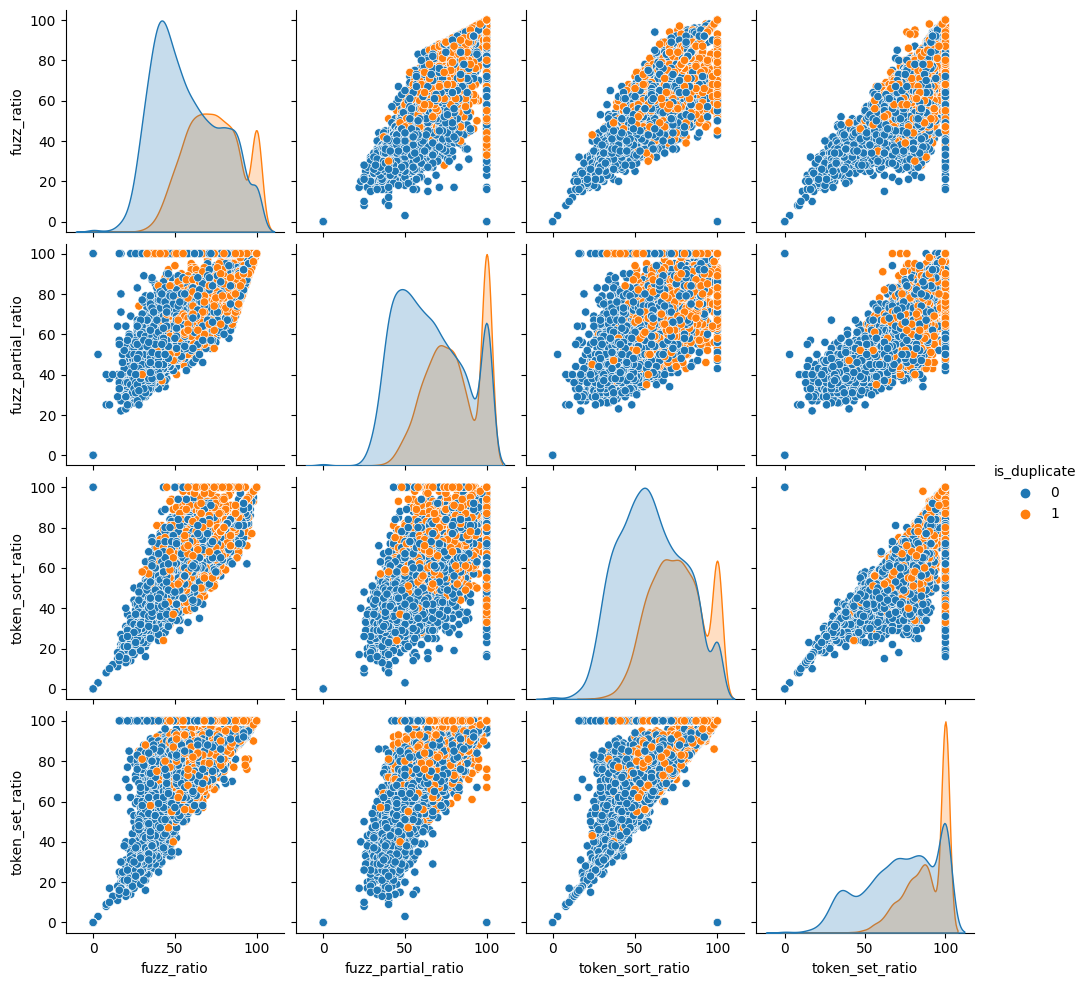

In [66]:
## Fuzzy Features Plot
sns.pairplot(df_final[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],
             hue='is_duplicate')

TF-IDF Vectorizer

In [444]:
# Converting the textual data to numerical data
tfidf = TfidfVectorizer(ngram_range = (1,1),min_df = 5,max_df = 0.9,strip_accents = 'unicode',
                        smooth_idf = 1,sublinear_tf = 1,max_features = 500)

# Merge text
merge_questions = list(df_final["question1"]) + list(df_final["question2"])
# Fit on training merge data
tfidf_vector = tfidf.fit_transform(merge_questions)
q1_arr, q2_arr = np.vsplit(tfidf_vector.toarray(),2)

In [445]:
df1 = pd.DataFrame(q1_arr, index = df_final.index)
df2 = pd.DataFrame(q2_arr, index = df_final.index)
tfidf_vec = pd.concat([df1,df2], axis=1)
tfidf_vec.shape

(1000, 1000)

In [446]:
tfidf_vec

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Word2vec Embedding

In [447]:
from gensim.models import KeyedVectors

## Path of the downloaded model
filename = r'/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
## load into gensim
w2vec = KeyedVectors.load_word2vec_format(filename, binary=True)

In [448]:
df_final["question1"][0]

'best market autom tool small mid size compani'

In [449]:
vocab = list(w2vec.key_to_index.keys())

In [450]:
vocab[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

Word2vec Embedding Function

In [451]:
def w2vec_embedding_func(df):
    w2vec_list = []
    
    for sentence in df:
        doc_tokens = sentence.split()
        
        token_list = []
        for token in doc_tokens:
            if token in vocab:
                tok_vec = w2vec.get_vector(token)
                token_list.append(tok_vec)
        if len(token_list)==0:
            token_list.append([0]*len(tok_vec))
                
        w2vec_list.append(np.mean(token_list,axis=0))
    
    return w2vec_list

In [452]:
w2vec_q1 = w2vec_embedding_func(df_final["question1"])
w2vec_q2 = w2vec_embedding_func(df_final["question2"])

In [453]:
len(w2vec_q1) , len(w2vec_q2)

(1000, 1000)

In [454]:
df_w2vec_q1 = pd.DataFrame(data=w2vec_q1)
df_w2vec_q2 = pd.DataFrame(data=w2vec_q2)

In [455]:
df_w2vec_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.059509,0.064290,0.004720,0.050720,-0.023783,-0.097575,0.044718,-0.103597,0.134420,0.064138,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0.115336,0.169434,0.047119,0.044189,-0.038798,0.164246,0.129232,-0.113770,0.010905,0.087240,...,-0.046224,0.258952,-0.123128,-0.034536,-0.035034,-0.044922,-0.004842,-0.054525,0.054036,-0.021240
2,-0.087307,0.093886,0.002686,0.129612,-0.069661,0.020284,0.106536,-0.109280,0.088557,0.060455,...,-0.114366,0.136129,-0.160563,0.021749,-0.037082,-0.013496,-0.059635,-0.037123,0.051975,-0.102553
3,-0.005615,0.037638,0.136414,0.089111,-0.068019,0.043132,-0.012070,-0.094727,-0.069051,0.072591,...,0.013367,0.100138,-0.095186,-0.051320,-0.044860,-0.117757,-0.115967,-0.022156,-0.011688,0.065063
4,-0.144531,0.417969,0.009827,0.030273,-0.119141,0.069336,-0.013733,-0.147461,0.041016,0.249023,...,-0.004944,-0.120605,-0.052246,0.077148,-0.087402,-0.359375,-0.150391,-0.186523,-0.384766,0.263672


In [456]:
df_w2vec_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.059509,0.064290,0.004720,0.050720,-0.023783,-0.097575,0.044718,-0.103597,0.134420,0.064138,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0.163330,0.103760,-0.040466,0.081686,-0.093491,0.098099,0.081665,-0.142456,-0.058350,0.122681,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0.002737,0.003723,-0.001495,0.072800,-0.032654,0.087589,0.025101,-0.032150,-0.027383,0.030754,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,-0.038725,-0.028827,0.011951,0.105511,-0.092981,0.120911,0.033453,-0.049603,0.089258,0.063794,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0.062174,0.135824,0.079936,-0.012207,-0.125977,0.070719,0.163717,-0.167969,0.223958,0.239583,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277


Final Dataframe for model training

In [457]:
drop_col = ["id","qid1","qid2","question1","question2"]
df_model_tfidf = pd.concat([df_final.drop(columns=drop_col,axis=1),tfidf_vec],axis=1)
df_model_w2vec = pd.concat([df_final.drop(columns=drop_col,axis=1),df_w2vec_q1,df_w2vec_q2],axis=1)

In [458]:
df_model_tfidf.shape, df_model_w2vec.shape

((1000, 1028), (1000, 628))

In [459]:
## TfIDF model
df_model_tfidf.head()

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [460]:
df_model_tfidf

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0,11,6,5,3,6,3,2,35,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0,7,5,3,3,4,2,1,16,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0,4,4,2,2,2,2,0,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [461]:
df1 = df_model_tfidf.copy()

In [462]:
df1.dropna(axis=0)

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0,11,6,5,3,6,3,2,35,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0,7,5,3,3,4,2,1,16,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0,4,4,2,2,2,2,0,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [463]:
## Word2vec model
df_model_w2vec.head()

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,290,291,292,293,294,295,296,297,298,299
0,1,13,13,8,8,5,5,5,45,45,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0,12,15,3,4,9,11,5,16,19,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0,26,20,9,11,17,9,3,48,75,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,0,13,30,6,12,7,18,0,32,74,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0,5,9,4,5,1,4,0,25,31,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277


In [464]:
df2 = df_model_w2vec.copy()

In [465]:
df2.dropna(axis=0)

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,290,291,292,293,294,295,296,297,298,299
0,1,13,13,8,8,5,5,5,45,45,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0,12,15,3,4,9,11,5,16,19,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0,26,20,9,11,17,9,3,48,75,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,0,13,30,6,12,7,18,0,32,74,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0,5,9,4,5,1,4,0,25,31,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,-0.000685,0.122540,-0.104547,0.013887,-0.085473,0.018874,-0.085920,-0.054588,-0.023691,-0.004309
996,0,11,6,5,3,6,3,2,35,16,...,0.233073,0.114553,0.034749,0.089722,-0.075114,-0.065308,-0.137207,-0.001081,-0.117839,-0.004387
997,0,7,5,3,3,4,2,1,16,17,...,-0.117106,0.138997,-0.224854,0.009079,0.001785,-0.078756,-0.031840,0.002909,0.168172,0.014893
998,0,4,4,2,2,2,2,0,12,12,...,0.020874,0.112061,-0.124512,-0.228699,-0.017899,-0.139800,0.088745,-0.131836,-0.110596,0.013550


Spliting features & target values

In [466]:
x_tfidf = df_model_tfidf.drop(columns="is_duplicate",axis=1)
y_tfidf = df_model_tfidf["is_duplicate"]

x_w2vec = df_model_w2vec.drop(columns="is_duplicate",axis=1)
y_w2vec = df_model_w2vec["is_duplicate"]

In [467]:
x_tfidf.shape,y_tfidf.shape

((1000, 1027), (1000,))

In [468]:
x_w2vec.shape,y_w2vec.shape

((1000, 627), (1000,))

In [469]:
y_w2vec.dtype,y_tfidf.dtype

(dtype('O'), dtype('O'))

In [470]:
## Change datatype of target from object to int64
y_tfidf = y_tfidf.astype("int64")
y_w2vec = y_w2vec.astype("int64")

In [471]:
y_w2vec.dtype,y_tfidf.dtype

(dtype('int64'), dtype('int64'))

Spliting data into train and test

In [472]:
# Importing the train test split function
from sklearn.model_selection import train_test_split

x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(x_tfidf,y_tfidf,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf)

x_train_w2vec,x_test_w2vec,y_train_w2vec,y_test_w2vec = train_test_split(x_w2vec,y_w2vec,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_w2vec)

In [473]:
x_train_tfidf.shape, x_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

((700, 1027), (300, 1027), (700,), (300,))

In [474]:
x_train_w2vec.shape, x_test_w2vec.shape, y_train_w2vec.shape, y_test_w2vec.shape

((700, 627), (300, 627), (700,), (300,))

Standardization

In [475]:
x_train_tfidf.head()

,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,word_common,...,490,491,492,493,494,495,496,497,498,499
582,16,4,8,3,8,1,1,45,17,0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
671,30,9,16,5,14,4,3,83,34,4,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
56,8,9,4,4,4,5,4,25,26,3,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
908,11,14,7,9,4,5,3,38,58,3,...,0.0,0.0,0.0,0.0,0.386202,0.0,0.0,0.0,0.0,0.0
914,7,7,3,3,4,4,4,19,20,2,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [476]:
x_train_tfidf.columns = x_train_tfidf.columns.astype(str)
x_test_tfidf.columns = x_test_tfidf.columns.astype(str)
x_train_w2vec.columns = x_train_w2vec.columns.astype(str)
x_test_w2vec.columns = x_test_w2vec.columns.astype(str)

In [477]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
x_train_tfidf = scaler.fit_transform(x_train_tfidf)
x_test_tfidf = scaler.transform(x_test_tfidf)

x_train_w2vec = scaler.fit_transform(x_train_w2vec)
x_test_w2vec = scaler.transform(x_test_w2vec)

In [478]:
df_final.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,...,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,398782,496695,532029,best market autom tool small mid size compani,best market autom tool small mid size compani,1,13,13,8,8,...,1.0,1.0,1.0,1.0,1.0,1.0,100,100,100,100
1,115086,187729,187730,poor want invest,quit poor want rich,0,12,15,3,4,...,0.555556,0.454545,0.583333,0.466667,0.0,0.0,63,73,51,72
2,327711,454161,454162,india live abroad meet guy franc parti want date,e thapar univers thapar univers institut engin...,0,26,20,9,11,...,0.333333,0.176471,0.15,0.115385,0.0,0.0,37,40,37,39
3,367788,498109,491396,mani peopl u hate southern state,boyfriend doesnt feel guilti hurt cri tell kil...,0,13,30,6,12,...,0.0,0.0,0.0,0.0,0.0,0.0,34,44,36,36
4,151235,237843,50930,consequ bhopal ga tragedi,reason behind bhopal ga tragedi,0,5,9,4,5,...,0.0,0.0,0.6,0.333333,0.0,1.0,75,76,61,81


In [479]:
df_null = df_final.drop(columns=['id','qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [480]:
df_null.isnull().sum()

q1_token              0
q2_token              0
q1_words              0
q2_words              0
q1_stops              0
q2_stops              0
common_stopwords      0
q1_len                0
q2_len                0
word_common           0
common_tokens         0
word_total            0
word_share            0
mean_len              0
abs_len_diff          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
first_word_eq         0
last_word_eq          0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [481]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   q1_token            1000 non-null   object
 1   q2_token            1000 non-null   object
 2   q1_words            1000 non-null   object
 3   q2_words            1000 non-null   object
 4   q1_stops            1000 non-null   object
 5   q2_stops            1000 non-null   object
 6   common_stopwords    1000 non-null   object
 7   q1_len              1000 non-null   object
 8   q2_len              1000 non-null   object
 9   word_common         1000 non-null   object
 10  common_tokens       1000 non-null   object
 11  word_total          1000 non-null   object
 12  word_share          1000 non-null   object
 13  mean_len            1000 non-null   object
 14  abs_len_diff        1000 non-null   object
 15  cwc_min             1000 non-null   object
 16  cwc_max             1000 

In [482]:
df_null.columns[:-4]

Index(['q1_token', 'q2_token', 'q1_words', 'q2_words', 'q1_stops', 'q2_stops',
       'common_stopwords', 'q1_len', 'q2_len', 'word_common', 'common_tokens',
       'word_total', 'word_share', 'mean_len', 'abs_len_diff', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'first_word_eq',
       'last_word_eq'],
      dtype='object')

In [483]:
for col in df_null.columns[:-4]:
    df_null[col] = df_null[col].astype('int64')

In [484]:
df_null

,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,word_common,...,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,13,13,8,8,5,5,5,45,45,8,...,1,1,1,1,1,1,100,100,100,100
1,12,15,3,4,9,11,5,16,19,2,...,0,0,0,0,0,0,63,73,51,72
2,26,20,9,11,17,9,3,48,75,0,...,0,0,0,0,0,0,37,40,37,39
3,13,30,6,12,7,18,0,32,74,0,...,0,0,0,0,0,0,34,44,36,36
4,5,9,4,5,1,4,0,25,31,3,...,0,0,0,0,0,1,75,76,61,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15,38,7,15,8,23,1,41,98,4,...,0,0,0,0,0,0,43,68,47,79
996,11,6,5,3,6,3,2,35,16,1,...,0,0,0,0,0,0,47,69,47,55
997,7,5,3,3,4,2,1,16,17,2,...,0,0,0,0,0,0,73,75,97,97
998,4,4,2,2,2,2,0,12,12,2,...,0,0,0,0,1,1,100,100,100,100


In [485]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   q1_token            1000 non-null   int64
 1   q2_token            1000 non-null   int64
 2   q1_words            1000 non-null   int64
 3   q2_words            1000 non-null   int64
 4   q1_stops            1000 non-null   int64
 5   q2_stops            1000 non-null   int64
 6   common_stopwords    1000 non-null   int64
 7   q1_len              1000 non-null   int64
 8   q2_len              1000 non-null   int64
 9   word_common         1000 non-null   int64
 10  common_tokens       1000 non-null   int64
 11  word_total          1000 non-null   int64
 12  word_share          1000 non-null   int64
 13  mean_len            1000 non-null   int64
 14  abs_len_diff        1000 non-null   int64
 15  cwc_min             1000 non-null   int64
 16  cwc_max             1000 non-null   int64
 

In [486]:
scaler.fit_transform(df_null)

array([[ 3.55651070e-01,  2.28713177e-01,  8.57438578e-01, ...,
         1.48535020e+00,  1.76016699e+00,  1.06093283e+00],
       [ 1.75756750e-01,  5.31043879e-01, -8.14633532e-01, ...,
         1.56420006e-01, -7.05616718e-01, -2.63577570e-01],
       [ 2.69427723e+00,  1.28687064e+00,  1.19185300e+00, ...,
        -1.46782801e+00, -1.41012635e+00, -1.82460768e+00],
       ...,
       [-7.23714848e-01, -9.80609634e-01, -8.14633532e-01, ...,
         2.54859280e-01,  1.60920064e+00,  9.19021002e-01],
       [-1.26339781e+00, -1.13177499e+00, -1.14904795e+00, ...,
         1.48535020e+00,  1.76016699e+00,  1.06093283e+00],
       [ 7.15439709e-01,  3.79878528e-01,  8.57438578e-01, ...,
         1.07200369e-01, -1.10708656e-03, -7.43617982e-02]])

Model Training Function

In [487]:
def model_train_func(model,x_train,y_train,x_test,y_test):
    
    ## Fit on training data
    model.fit(x_train,y_train)
    
    ## Predict values using train data
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_train_predict = model.predict(x_train)
    ## Predict values using validation data
    y_test_prob = model.predict_proba(x_test)[:,1]
    y_test_predict = model.predict(x_test)
    
    ## Model Evaluation
    # F1 score on train-test data
    train_f1score = f1_score(y_train,y_train_predict)
    test_f1score = f1_score(y_test,y_test_predict)
    
    ## Confusion matrix
    cf_matrix=confusion_matrix(y_test,y_test_predict)
    print(cf_matrix)
    sns.heatmap(cf_matrix,annot=True)
    
    print(f"F1 score on train data ={train_f1score}")
    print(f"F1 score on test data ={test_f1score}")
    print(classification_report(y_test,y_test_predict))
    
    return y_train_prob,y_test_prob,accuracy_score(y_test,y_test_predict),test_f1score

In [488]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

#Stratified k-Fold Cross Validation with shuffle split 
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

Model 1 : Logistic Regression

In [489]:
def Val_score_func(c_list,x_train,y_train):
    avg_fscore = []
    
    for i in c_list:
        f_score = cross_val_score(estimator= LogisticRegression(C=i,random_state=11,n_jobs=-1),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [490]:
# Cross validation
c = [1,3,5,7]
fscore_logreg_tfidf = Val_score_func(c,x_train_tfidf,y_train_tfidf)
fscore_logreg_w2vec = Val_score_func(c,x_train_w2vec,y_train_w2vec)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [491]:
pd.DataFrame({'C': c, 'f_Score_tfidf':fscore_logreg_tfidf,'f_Score_w2vec':fscore_logreg_w2vec})

,C,f_Score_tfidf,f_Score_w2vec
0,1,0.553171,0.495660
1,3,0.540939,0.489911
2,5,0.540535,0.486988
3,7,0.537837,0.481339


Text(0.5, 1.0, 'Mean Validation score')

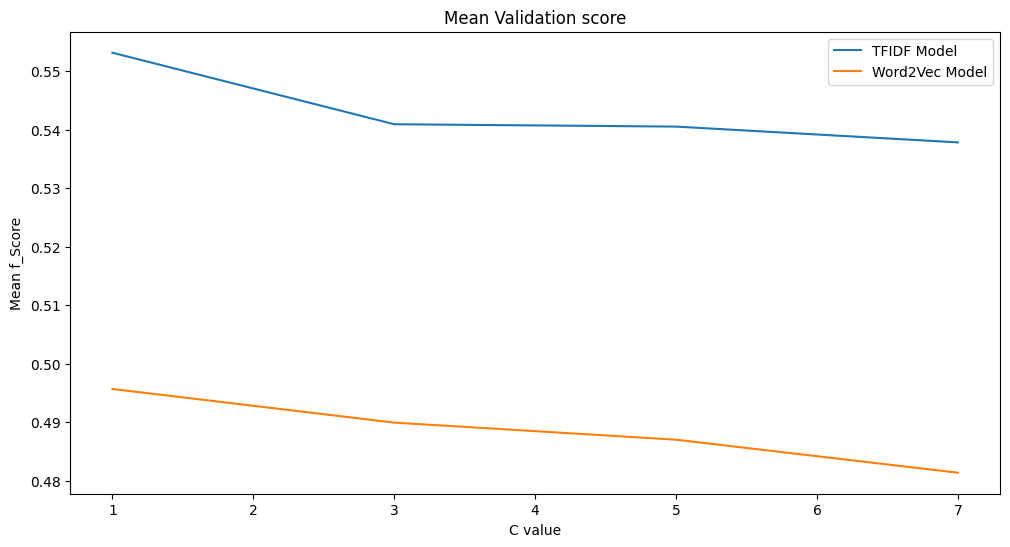

In [492]:
plt.figure(figsize=(12,6))
plt.plot(c,fscore_logreg_tfidf,label='TFIDF Model')
plt.plot(c,fscore_logreg_w2vec,label='Word2Vec Model')
plt.xlabel('C value')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

Take C = 3 as optimal value

[[140  46]
 [ 64  50]]
F1 score on train data =0.9981167608286252
F1 score on test data =0.4761904761904762
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       186
           1       0.52      0.44      0.48       114

    accuracy                           0.63       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.62      0.63      0.63       300



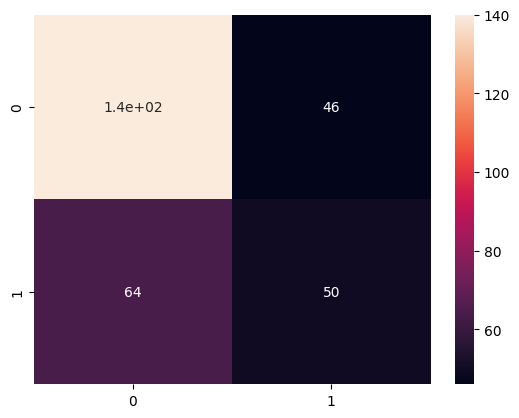

In [493]:
model_logreg = LogisticRegression(penalty='l2',C=3,solver='lbfgs',class_weight='balanced',
                                  verbose=0,random_state=11,n_jobs=-1)

y_train_prob_logreg,y_test_prob_logreg,accu_logreg,f1score_logreg = model_train_func(model_logreg,
                                                                                     x_train_tfidf,y_train_tfidf,
                                                                                     x_test_tfidf,y_test_tfidf)

Model 2 : Support Vector Machine (SVM)

In [494]:
from sklearn import svm

In [495]:
def Val_score_func(c_list,x_train,y_train):
    avg_fscore = []
    
    for i in c_list:
        f_score = cross_val_score(estimator=svm.SVC(C=i,kernel='rbf',class_weight='balanced',random_state=11,probability=True),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [496]:
# Cross validation
c = [1,5,7,11]
fscore_svm_tfidf = Val_score_func(c,x_train_tfidf,y_train_tfidf)
fscore_svm_w2vec = Val_score_func(c,x_train_w2vec,y_train_w2vec)

In [497]:
pd.DataFrame({'C': c, 'f_Score_tfidf':fscore_svm_tfidf,'f_Score_w2vec':fscore_svm_w2vec})

,C,f_Score_tfidf,f_Score_w2vec
0,1,0.586335,0.585784
1,5,0.521677,0.519463
2,7,0.513659,0.522414
3,11,0.526131,0.522414


Text(0.5, 1.0, 'Mean Validation score')

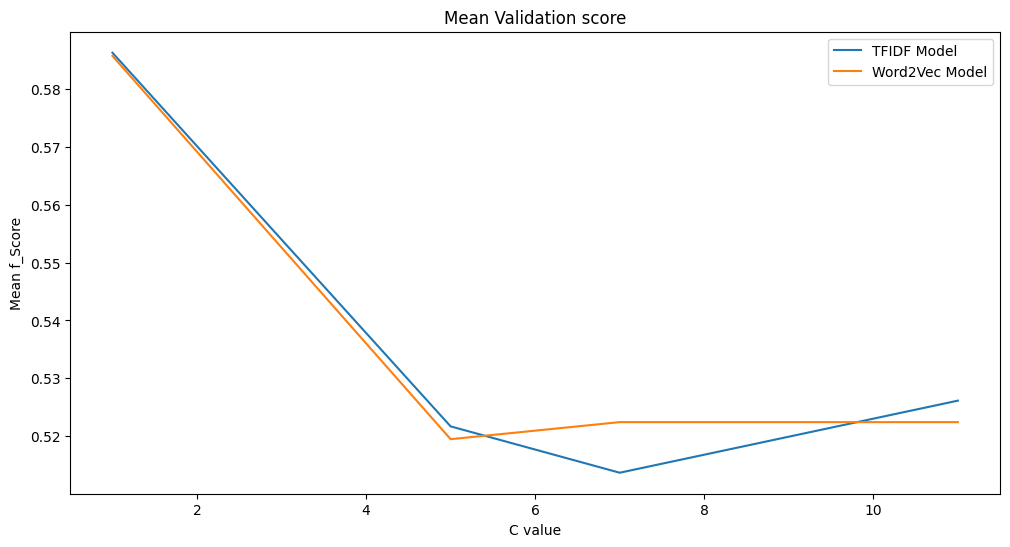

In [498]:
plt.figure(figsize=(12,6))
plt.plot(c,fscore_svm_tfidf,label='TFIDF Model')
plt.plot(c,fscore_svm_w2vec,label='Word2Vec Model')
plt.xlabel('C value')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

Take C=1 as optimal value

[[152  34]
 [ 66  48]]
F1 score on train data =0.9211908931698775
F1 score on test data =0.48979591836734687
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       186
           1       0.59      0.42      0.49       114

    accuracy                           0.67       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.65      0.67      0.65       300



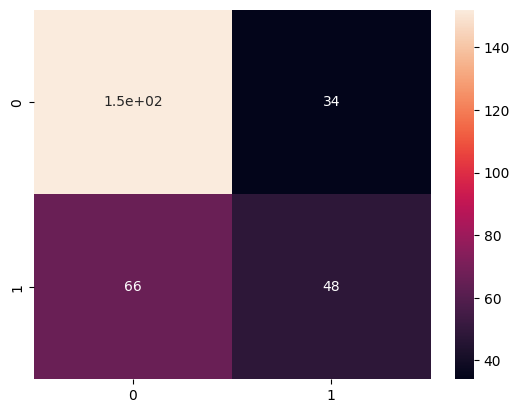

In [499]:
model_SVM = svm.SVC(C=1,kernel='rbf',class_weight='balanced',random_state=11,probability=True)

y_train_prob_SVM,y_test_prob_SVM,accu_SVM,f1score_SVM = model_train_func( model_SVM,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

Model 3 : Random Forest

In [500]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RandomizedSearchCV

In [501]:
def Val_score_func(max_depth,x_train,y_train):
    avg_fscore = []
    
    for i in max_depth:
        f_score = cross_val_score(estimator=RFC(n_estimators=200,max_depth=i,min_samples_split=5,min_samples_leaf=5,max_features='sqrt',
                                                n_jobs=-1,random_state=11,class_weight='balanced'),
                                                X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [502]:
depth = [3,5,7,10,15]
fscore_RFC_tfidf = Val_score_func(depth,x_train_tfidf,y_train_tfidf)
fscore_RFC_w2vec = Val_score_func(depth,x_train_w2vec,y_train_w2vec)

In [503]:
pd.DataFrame({'max_depth': depth, 'f_Score_tfidf':fscore_RFC_tfidf,'f_Score_w2vec':fscore_RFC_w2vec})

,max_depth,f_Score_tfidf,f_Score_w2vec
0,3,0.633538,0.619069
1,5,0.629241,0.627489
2,7,0.624971,0.576017
3,10,0.629539,0.519209
4,15,0.631733,0.492789


Text(0.5, 1.0, 'Mean Validation score')

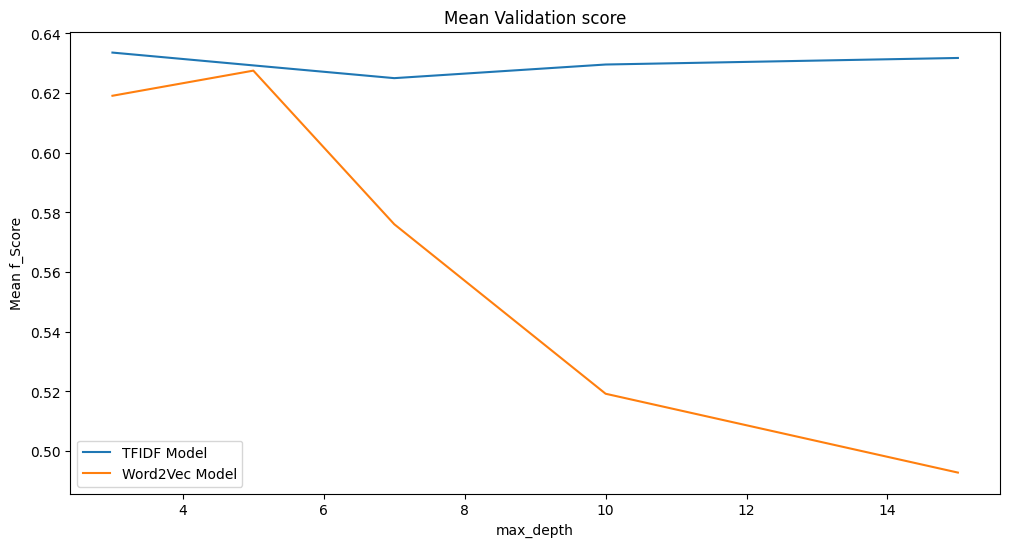

In [504]:
plt.figure(figsize=(12,6))
plt.plot(depth,fscore_RFC_tfidf,label='TFIDF Model')
plt.plot(depth,fscore_RFC_w2vec,label='Word2Vec Model')
plt.xlabel('max_depth')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

Take max_depth = 3 as optimal value

[[106  80]
 [ 15  99]]
F1 score on train data =0.662807525325615
F1 score on test data =0.6757679180887373
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       186
           1       0.55      0.87      0.68       114

    accuracy                           0.68       300
   macro avg       0.71      0.72      0.68       300
weighted avg       0.75      0.68      0.68       300



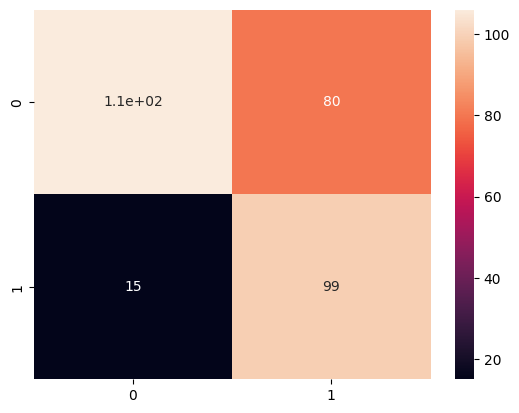

In [505]:
model_RFC = RFC(n_estimators=200,max_depth=3,min_samples_split=5,min_samples_leaf=5,max_features='sqrt',
            n_jobs=-1,random_state=11,class_weight='balanced')

y_train_prob_RFC,y_test_prob_RFC,accu_RFC,f1score_RFC = model_train_func( model_RFC,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

Model 4 : XGBoost Model

In [506]:
import xgboost as xgb

In [507]:
def Val_score_func(max_depth,x_train,y_train):
    avg_fscore = []
    
    for i in max_depth:
        f_score = cross_val_score(estimator=xgb.XGBClassifier(n_estimators=200,max_depth=i,n_jobs=-1,subsample=0.8),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [508]:
depth = [3,5,7,10,15]
fscore_XGB_tfidf = Val_score_func(depth,x_train_tfidf,y_train_tfidf)
fscore_XGB_w2vec = Val_score_func(depth,x_train_w2vec,y_train_w2vec)

In [509]:
pd.DataFrame({'max_depth': depth, 'f_Score_tfidf':fscore_XGB_tfidf,'f_Score_w2vec':fscore_XGB_w2vec})

,max_depth,f_Score_tfidf,f_Score_w2vec
0,3,0.544088,0.511378
1,5,0.555079,0.534003
2,7,0.545237,0.504635
3,10,0.555751,0.543358
4,15,0.573340,0.530298


Text(0.5, 1.0, 'Mean Validation score')

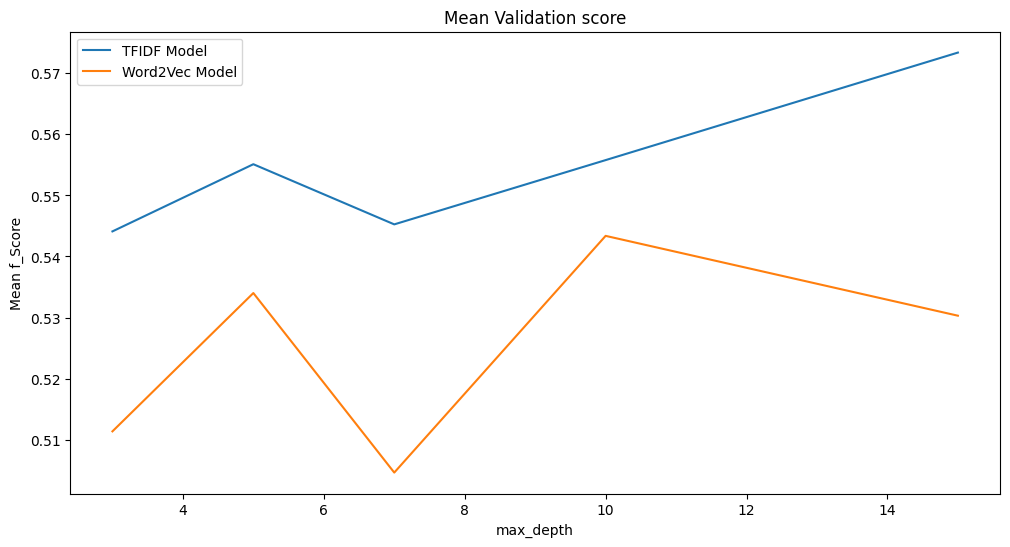

In [510]:
plt.figure(figsize=(12,6))
plt.plot(depth,fscore_XGB_tfidf,label='TFIDF Model')
plt.plot(depth,fscore_XGB_w2vec,label='Word2Vec Model')
plt.xlabel('max_depth')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

Take max_depth = 3 as optimal value

[[138  48]
 [ 58  56]]
F1 score on train data =1.0
F1 score on test data =0.5137614678899082
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       186
           1       0.54      0.49      0.51       114

    accuracy                           0.65       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.64      0.65      0.64       300



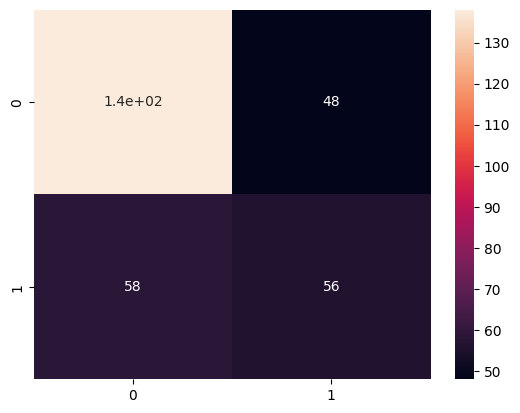

In [511]:
model_XGB= xgb.XGBClassifier(n_estimators=200,max_depth=3,n_jobs=-1,subsample=0.8)

y_train_prob_XGB,y_test_prob_XGB,accu_XGB,f1score_XGB = model_train_func( model_XGB,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

Combine Model

In [512]:
final_train_pred_prob = (y_train_prob_logreg + y_train_prob_SVM + y_train_prob_RFC + y_train_prob_XGB)/4
final_test_pred_prob = (y_test_prob_logreg + y_test_prob_SVM + y_test_prob_RFC + y_test_prob_XGB)/4

final_train_pred = [1 if i > 0.3 else 0 for i in final_train_pred_prob]
final_test_pred = [1 if i > 0.3 else 0 for i in final_test_pred_prob]

In [513]:
final_train_accu = accuracy_score(y_train_tfidf,final_train_pred)
final_test_accu = accuracy_score(y_test_tfidf,final_test_pred)
final_train_f1score = f1_score(y_train_tfidf,final_train_pred)
final_test_f1score = f1_score(y_test_tfidf,final_test_pred)

print("Train Accuracy:",final_train_accu)
print("Test Accuracy:",final_test_accu)
print("Train f1score:",final_train_f1score)
print("Test f1score:",final_test_f1score)

Train Accuracy: 0.9628571428571429
Test Accuracy: 0.64
Train f1score: 0.9532374100719425
Test f1score: 0.6197183098591549


Model Performance Comparision

In [514]:
model=['Logistic Regression','Support Vector Machine','Random Forest','XGBoost','Combine Model']
accuracy=[accu_logreg,accu_SVM,accu_RFC,accu_XGB,final_test_accu]
f_score=[f1score_logreg,f1score_SVM,f1score_RFC,f1score_XGB,final_test_f1score]

model_df=pd.DataFrame({"Model":model,"Accuracy":accuracy,"F1_score":f_score})
model_df.sort_values(by=["F1_score"],ascending=False)

,Model,Accuracy,F1_score
2,Random Forest,0.683333,0.675768
4,Combine Model,0.640000,0.619718
3,XGBoost,0.646667,0.513761
1,Support Vector Machine,0.666667,0.489796
0,Logistic Regression,0.633333,0.476190
